# Multi-Model Classification | Bank Product Assessment 
Author: Miguel Santana | Flatiron Review: 10/14/2020, 12-12:45pm

# Project Methodology & Goal
A Portuguese financial institution provided data resulting from various direct telemarketing campaigns with the goal of predicting subscriber term deposits. The following will include an in depth analysis of the client, campaign, social, economic and additional features that lend to predicting whether a client will subscribe a term deposit. The analysis will culminate in actionable business recommendations that will drive the target variable.

## Data Analysis and Modeling
OSEMN Framework
* Obtain
* Scrub
* Explore
* Model
* INterpret

# OBTAIN

<div class="alert alert-block alert-info">

Dataset Citation:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Available via:
* [UCI's Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)

* [Kaggle](https://www.kaggle.com/henriqueyamahata/bank-marketing) 

</div>

#### Python Project Libraries
Importing Packages & Processing our Dataset

In [1]:
# Math, Visualizations, Cleaning and Analysis
import pandas as pd # data cleaning and manipulation
import numpy as np # numerical operations  
import seaborn as sns # visualizations / plt.style.use('seaborn-poster') 
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine Learning / Reporting
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Import data
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

### Variable Key
The dataset includes the following client, campaign, social, economic and other attributes:

**Client Data**
* Age
* Job Type
* Marital Status
* Education 
* Default (client credit in default)
* Housing (client housing loan)
* Loan (client personal loan)

**Current Campaign | Last Contact** 
* Contact Type
* Month 
* Day of Week 
* Duration (in seconds)

**Other Attributes:**
* Campaign (number of contacts/this campaign)
* Pdays (days since last contacted/previous campaign)
* Previous (contacts performed before this campaign/this client)
* Poutcome (previous campaign outcome)

**Social & Economic Context Attributes**
* Emp.var.rate (quarterly employment variation rate)
* Cons.price.idx (monthly indicator - consumer price index)
* Cons.conf.idx (monthly indicator - consumer confidence index)
* Euribor3m (daily indicator - euribor 3 month rate)
* Nr.employed (quarterly indicator - number of employees)

**Output/Target**
* y (has the client subscribed a term deposit?)

In [4]:
df = df.rename(columns={'y':'term_deposit'})

In [5]:
print(df.shape)
df.head(3)

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# SCRUB

In [6]:
for col in df.columns: # preliminary view of value counts per column
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

age 31    1947
32    1846
33    1833
36    1780
35    1759
Name: age, dtype: int64


job admin.         10422
blue-collar     9254
technician      6743
services        3969
management      2924
Name: job, dtype: int64


marital married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


education university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
Name: education, dtype: int64


default no         32588
unknown     8597
yes            3
Name: default, dtype: int64


housing yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


loan no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


contact cellular     26144
telephone    15044
Name: contact, dtype: int64


month may    13769
jul     7174
aug     6178
jun     5318
nov     4101
Name: month, dtype: int64


day_of_week thu    8623
mon    8514
wed    8134

## Null & Unknown Values

In [7]:
print('Missing values : ', df.isnull().sum().values.sum()) # null values

Missing values :  0


<div class="alert alert-success">

There are no missing values in the dataset. There are a substantial number of "unknown" values that will need to be addressed.  

</div> 

#### Addressing Unknown Variables

In [8]:
print('Unknown Values Per Column')
for col in df.columns: # preliminary view of value counts per column
    try:
        print(col, df[col].value_counts()['unknown'])
    except:
        pass

Unknown Values Per Column
job 330
marital 80
education 1731
default 8597
housing 990
loan 990


<div class="alert alert-success">

In order to narrow down the data, I will drop the "unknown" values from each column except for 'default'. After processing both updates ('unknown' & outlier removal) I will retain over 90% of my original dataset.

</div> 

In [9]:
orig_len = len(df)

In [10]:
unkcols = ['job','marital','education','housing','loan']

for col in unkcols:
    df = df.loc[(df[col] != 'unknown')]

In [11]:
print(f'There were {orig_len - len(df)} unknown values removed from the dataset')
print(f'The dataframe represents {(len(df)/orig_len) * 100}% of the original data set.')

There were 2943 unknown values removed from the dataset
The dataframe represents 92.85471496552394% of the original data set.


## Outlier Removal

In [12]:
# IQR Outlier Removal Function
def iqr_outlier_rem(df, col_name):
    '''Removing outliers using the IQR method'''
    start_len = len(df)
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3-Q1 # Finding interquartile range
    lower_threshold  = Q1-1.5*IQR
    upper_threshold = Q3+1.5*IQR
    new_df = df.loc[(df[col_name] > lower_threshold) & (df[col_name] < upper_threshold)]
    print(f'There were {start_len - len(new_df)} outliers removed from {col_name}')
    return new_df

In [13]:
df = iqr_outlier_rem(df, 'age')

There were 412 outliers removed from age


In [14]:
print(f'The new dataframe represents {(len(df)/orig_len) * 100} percent of the original dataset.')

The new dataframe represents 91.85442361852967 percent of the original dataset.


<div class="alert alert-block alert-info">

The dataset now represents clients between the ages of 17 and 69 with a specific job status, marital status, education level and housing or personal loan status per bank records. 

The dataset will be separated in order to show features that are representative of "yes" in our target variable.

</div> 

<div class="alert alert-success">

Notable Data Columns / Feature Conversions 
    
* Duration - a duration of zero directly ties to the target 'no' (remove before modeling)
* Pdays - a value of 999 means the customer has not been contacted. 

</div> 

#### Final Updates For EDA

In [15]:
# Binning Ages for Visualizations
df['Age(bin)'] = df['age'].apply(lambda x: '17-25' if x < 25
                                 else '25-30' if x < 30 
                                 else '30-35' if x < 35
                                 else '35-40' if x < 40 
                                 else '40-45' if x < 45 
                                 else '45-50' if x < 50 
                                 else '50+')

In [16]:
educ = {'illiterate':'0-Years','basic.4y':'4-Years','basic.6y':'6-Years','basic.9y':'9-Years',
        'high.school':'HighSchool','professional.course':'ProCourse','university.degree':'University'}

df['education'] = df['education'].replace(educ)

# Exploratory Data Analysis

<div class="alert alert-block alert-info">

The following illustrations are representative of trends in converted customers. Analysis will show which customer segments and features are most common with regard to bank product performance.

</div> 

## Client Features
#### Age, Education Level & Job Type

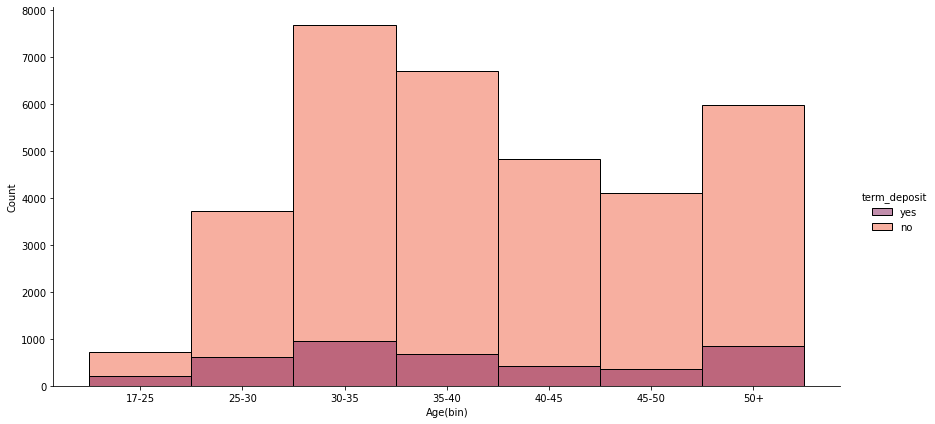

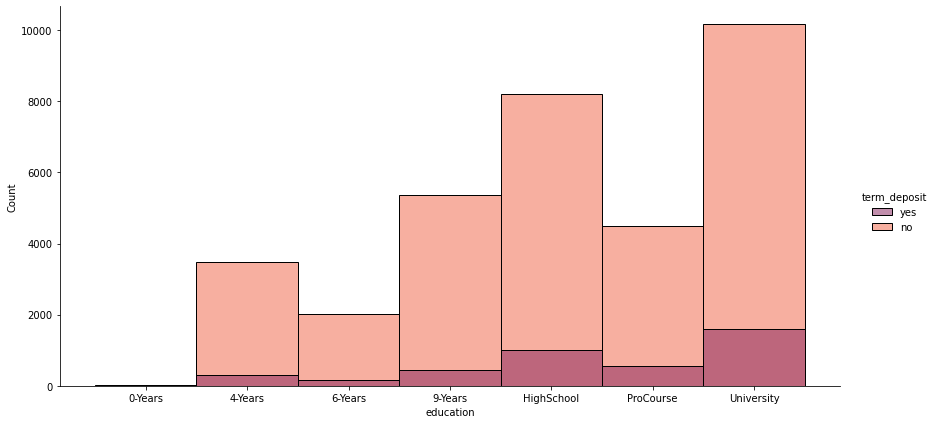

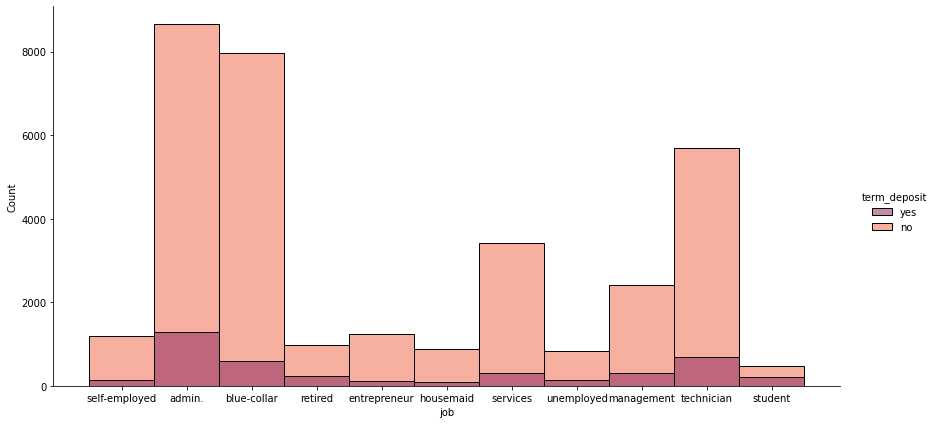

In [17]:
df = df.sort_values(['Age(bin)'], ascending=True)
sns.displot(df,x='Age(bin)',hue='term_deposit',height=6,aspect=2,palette='rocket',hue_order=['yes','no'])
df = df.sort_values(['education'], ascending=True)
sns.displot(df,x='education',hue='term_deposit',height=6,aspect=2,palette='rocket',hue_order=['yes','no'])
sns.displot(df,x='job',hue='term_deposit',height=6,aspect=2,palette='rocket',hue_order=['yes','no']);

<div class="alert alert-block alert-info">

The majority of subscribing consumers: 
* Have a university degree
* Work administrative jobs
* Age: Early thirties

</div> 

## Bank Features
#### Number of Employees (Quarterly)

In [18]:
# visualizing consumers who enroll/bank product
yesdf = df[df['term_deposit'] == 'yes']

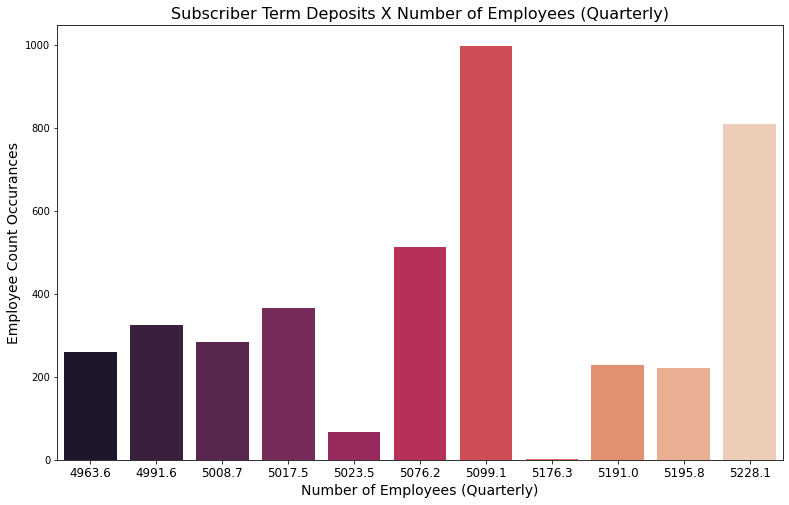

In [19]:
number_employees = yesdf['nr.employed'].value_counts()
df_number_employees = pd.DataFrame(number_employees)

x_counts = df_number_employees['nr.employed'].index
y_counts = df_number_employees['nr.employed']

fig, ax = plt.subplots()
fig.set_size_inches(13,8)
graph_number_employees = sns.barplot(x=x_counts, y=y_counts, data=df_number_employees, palette='rocket')
for item in graph_number_employees.get_xticklabels():
    item.set_rotation(0)
    item.set_size(12)
plt.title('Subscriber Term Deposits X Number of Employees (Quarterly)', fontdict={'fontsize': 16})
plt.ylabel('Employee Count Occurances', fontdict={'fontsize': 14})
plt.xlabel('Number of Employees (Quarterly)', fontdict={'fontsize': 14})
plt.show()

#### Number of Contacts | This Campaign

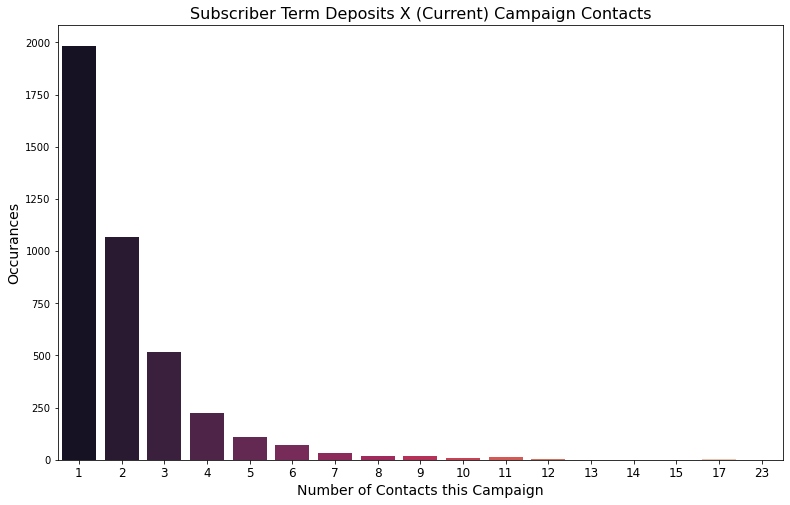

In [20]:
campaign = yesdf['campaign'].value_counts()
df_campaign = pd.DataFrame(campaign)

x_counts = df_campaign['campaign'].index
y_counts = df_campaign['campaign']

fig, ax = plt.subplots()
fig.set_size_inches(13,8)
graph_df_campaign = sns.barplot(x=x_counts, y=y_counts, data=df_campaign, palette='rocket')
for item in graph_df_campaign.get_xticklabels():
    item.set_rotation(0)
    item.set_size(12)
plt.title('Subscriber Term Deposits X (Current) Campaign Contacts', fontdict={'fontsize': 16})
plt.xlabel('Number of Contacts this Campaign', fontdict={'fontsize': 14})
plt.ylabel('Occurances', fontdict={'fontsize': 14})
plt.show()

#### Days Since Last Contact

In [21]:
# Dropping 999, corresponds to no contact per key
pdaysdf = yesdf[yesdf['pdays']!= 999]

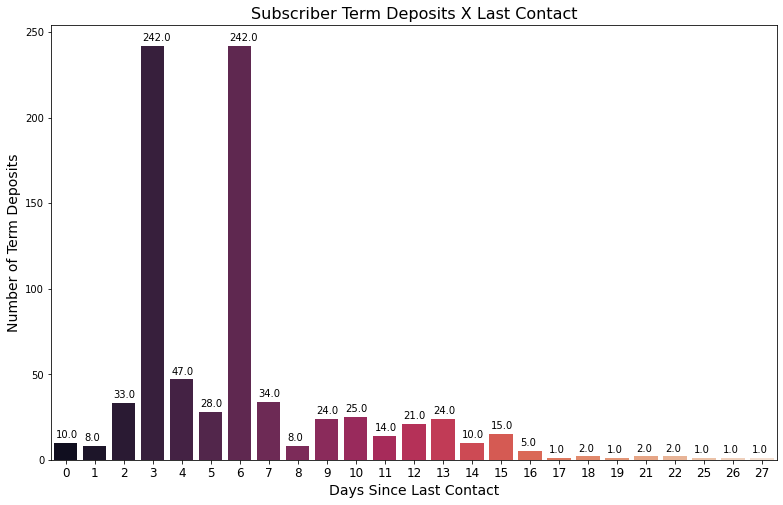

In [22]:
pdays = pdaysdf['pdays'].value_counts()
df_pdays = pd.DataFrame(pdays)

x_counts = df_pdays['pdays'].index
y_counts = df_pdays['pdays']

fig, ax = plt.subplots()
fig.set_size_inches(13,8)
graph_df_pdays = sns.barplot(x=x_counts, y=y_counts, data=df_pdays, palette='rocket')
for item in graph_df_pdays.get_xticklabels():
    item.set_rotation(0)
    item.set_size(12)
for a in graph_df_pdays.patches:
    ax.text(a.get_x()+0.05, a.get_height()+3,str(a.get_height()))
plt.title('Subscriber Term Deposits X Last Contact', fontdict={'fontsize': 16})
plt.xlabel('Days Since Last Contact', fontdict={'fontsize': 14})
plt.ylabel('Number of Term Deposits', fontdict={'fontsize': 14})
plt.show()

<div class="alert alert-block alert-info">

**Highest level of successful term deposits occur when:** 
* Bank employee levels are 5099 or 5228 (quarterly)
* During the first outreach | current campaign
* When obtained via means outside of campaigns (walk-ins / 999 = no contact)

</div> 

#### Data Preparation

In [23]:
df2 = df.copy() # Original for analysis

In [24]:
# drop duration per dataset guidelines
df = df.drop(['duration'], axis=1)

## Multicollinearity

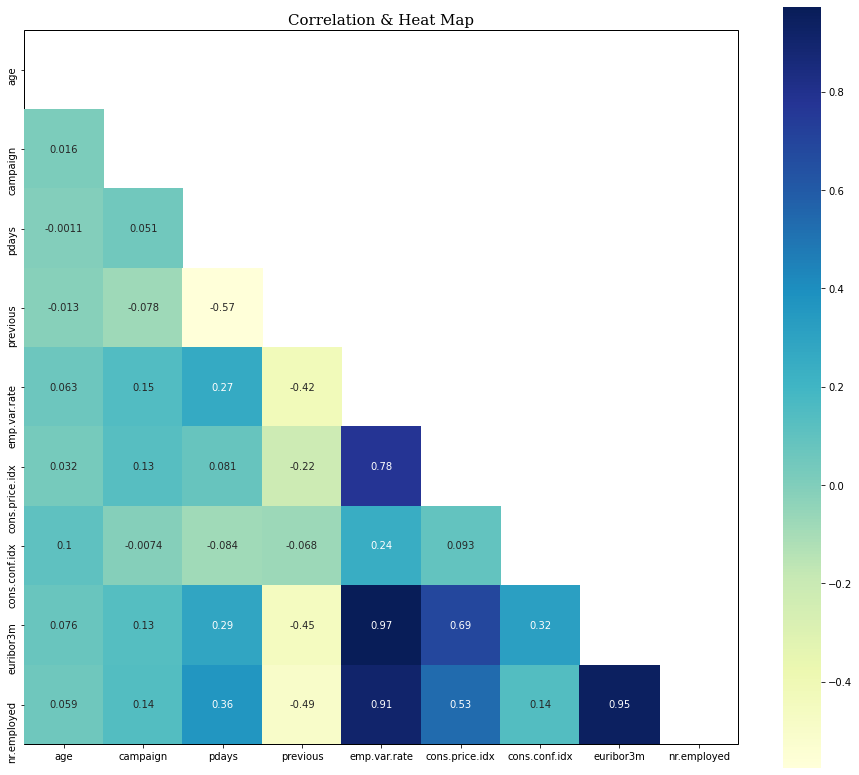

In [25]:
corr = df.corr() # analyzing correlation
fig, ax = plt.subplots(figsize=(16,14))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='YlGnBu')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
ax.set_title('Correlation & Heat Map', fontsize=15, fontfamily='serif')
plt.show()

# Pre-Model Processing
#### Dropping Features

In [26]:
# dropping features to address multicollinearity 
df = df.drop(['emp.var.rate', 'euribor3m','Age(bin)'],axis=1)

#### Cleaning Column Names

In [27]:
# Cleaning Column Names
subs = [(' ', '_'),('.0',''),('.',''),('-','_')]

def col_formatting(col):
    '''Replacing Column Features for Model Processing'''
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

### One-Hot Encoding

In [28]:
# One Hot Encode
df = pd.get_dummies(df,drop_first=True)

In [29]:
# Converting uint8 datatypes back to categorical variables 
for cat_cols in df.select_dtypes('uint8').columns:
         df[cat_cols] = df[cat_cols].astype('category')

In [30]:
# Identify X, y
y = df['term_deposit_yes']
X = df.drop(['term_deposit_yes'], axis=1) 

### Test/Train Split

In [31]:
# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101) 

### Standardize 

In [32]:
# standardize the data
scaler = StandardScaler() # transform "X" features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model

In [33]:
# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
def model_visuals (model, X_test, y_test):
    '''Plots the confusion matrix and ROC-AUC plot'''
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)  # confusion matrix
    metrics.plot_confusion_matrix(model, X_test, y_test, normalize = 'true', 
                          cmap = 'Blues', ax = axes[0])
    axes[0].set_title('Confusion Matrix');
    # ROC-AUC Curve
    roc_auc = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].set_title('ROC-AUC Plot')
    axes[1].grid()
    axes[1].legend()
    fig.tight_layout()
    plt.show()

## Logistic Regression

Accuracy Percentage 81.74 

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6738
           1       0.31      0.56      0.40       829

    accuracy                           0.82      7567
   macro avg       0.63      0.70      0.65      7567
weighted avg       0.87      0.82      0.84      7567
 




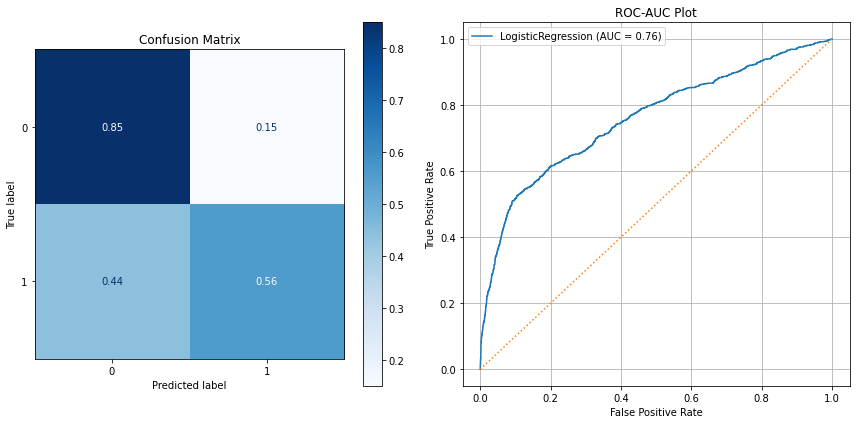

In [35]:
logreg_clf = LogisticRegression(class_weight = 'balanced') # Logistic Regression
logreg_clf.fit(X_train, y_train) # fit model
logreg_prediction = logreg_clf.predict(X_test)
lrs = round(accuracy_score(logreg_prediction, y_test)*100,2)
print('Accuracy Percentage', lrs, '\n')
print(classification_report(y_test, logreg_prediction), '\n\n')

model_visuals (logreg_clf, X_test, y_test) # class report / plots

## Random Forest

Accuracy Percentage 88.94 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6738
           1       0.49      0.23      0.32       829

    accuracy                           0.89      7567
   macro avg       0.70      0.60      0.63      7567
weighted avg       0.87      0.89      0.87      7567
 




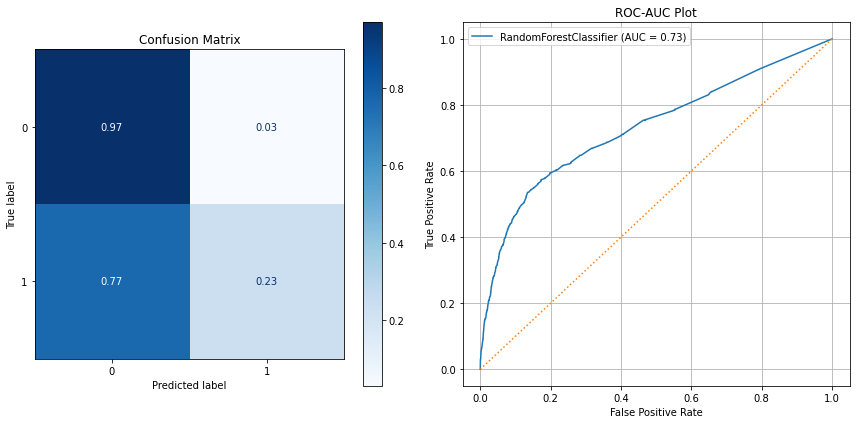

In [36]:
ranfor_clf = RandomForestClassifier(class_weight = 'balanced') # Random Forest 
ranfor_clf.fit(X_train, y_train) # fit model
ranfor_prediction = ranfor_clf.predict(X_test)
random_forest_score = round(accuracy_score(ranfor_prediction, y_test)*100,2)
print('Accuracy Percentage', random_forest_score, '\n')
print(classification_report(y_test, ranfor_prediction), '\n\n')

model_visuals (ranfor_clf, X_test, y_test) # class report / plots

## Support Vector Machine

Accuracy Percentage 83.18 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      6738
           1       0.34      0.56      0.42       829

    accuracy                           0.83      7567
   macro avg       0.64      0.71      0.66      7567
weighted avg       0.88      0.83      0.85      7567
 




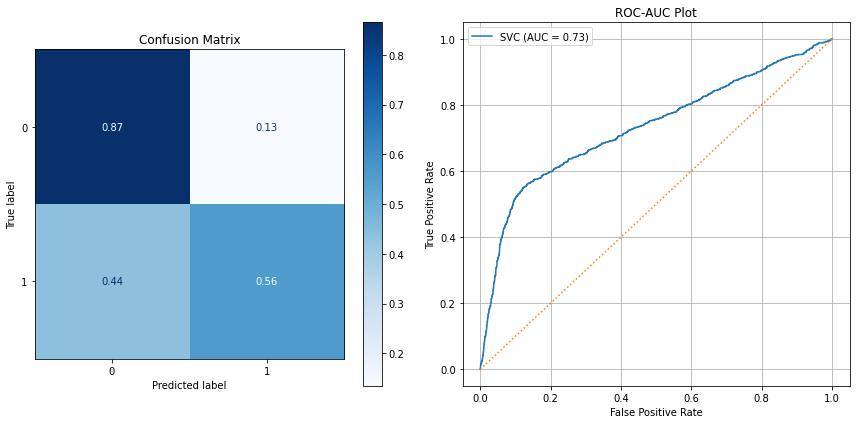

In [37]:
svm_clf = SVC(class_weight = 'balanced') # Support Vector Machine
svm_clf.fit(X_train, y_train) # fit model
svm_prediction = svm_clf.predict(X_test)
svm_score = round(accuracy_score(svm_prediction, y_test)*100,2)
print('Accuracy Percentage', svm_score, '\n')
print(classification_report(y_test, svm_prediction), '\n\n')

model_visuals (svm_clf, X_test, y_test) # class report / plots

## K-Nearest Neighbors

Accuracy Percentage 89.3 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6738
           1       0.53      0.23      0.32       829

    accuracy                           0.89      7567
   macro avg       0.72      0.60      0.63      7567
weighted avg       0.87      0.89      0.87      7567
 




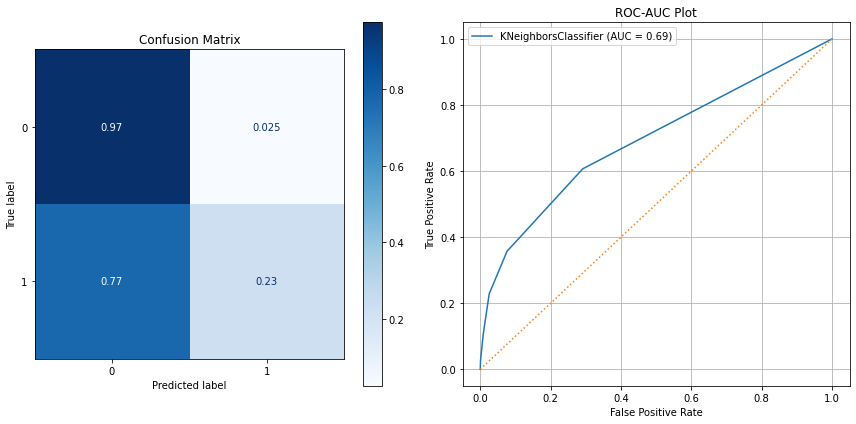

In [38]:
knn_clf = KNeighborsClassifier() # K-Nearest Neighbors
knn_clf.fit(X_train, y_train) # fit model
knn_prediction = knn_clf.predict(X_test)
knn_score = round(accuracy_score(knn_prediction, y_test)*100,2)
print('Accuracy Percentage', knn_score, '\n')
print(classification_report(y_test, knn_prediction), '\n\n')

model_visuals (knn_clf, X_test, y_test) # class report / plots

## Guassian Naive Bayes

Accuracy Percentage 66.88 

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      6738
           1       0.20      0.67      0.31       829

    accuracy                           0.67      7567
   macro avg       0.57      0.67      0.54      7567
weighted avg       0.86      0.67      0.73      7567
 




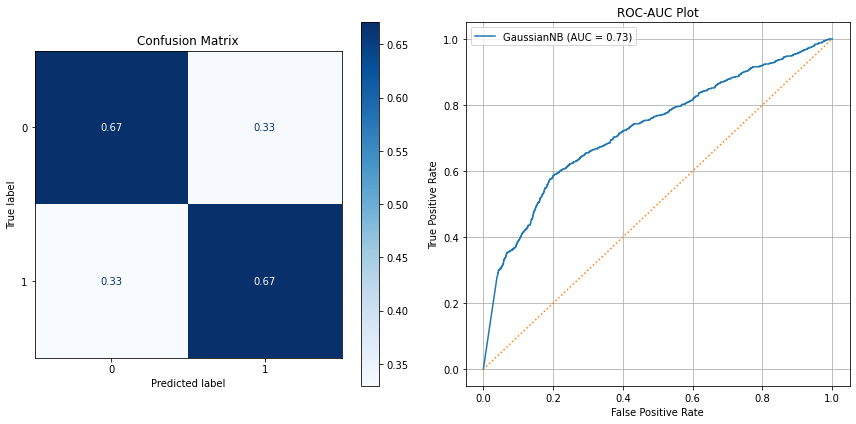

In [39]:
gaussian_clf = GaussianNB() # Guassian Naive Bayes
gaussian_clf.fit(X_train, y_train) # fit model
gaussian_prediction = gaussian_clf.predict(X_test)
gaussian_score = round(accuracy_score(gaussian_prediction, y_test)*100,2)
print('Accuracy Percentage', gaussian_score, '\n')
print(classification_report(y_test, gaussian_prediction), '\n\n')

model_visuals (gaussian_clf, X_test, y_test) # class report / plots

## Decision Tree

Accuracy Percentage 84.29 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6738
           1       0.29      0.30      0.29       829

    accuracy                           0.84      7567
   macro avg       0.60      0.60      0.60      7567
weighted avg       0.84      0.84      0.84      7567
 




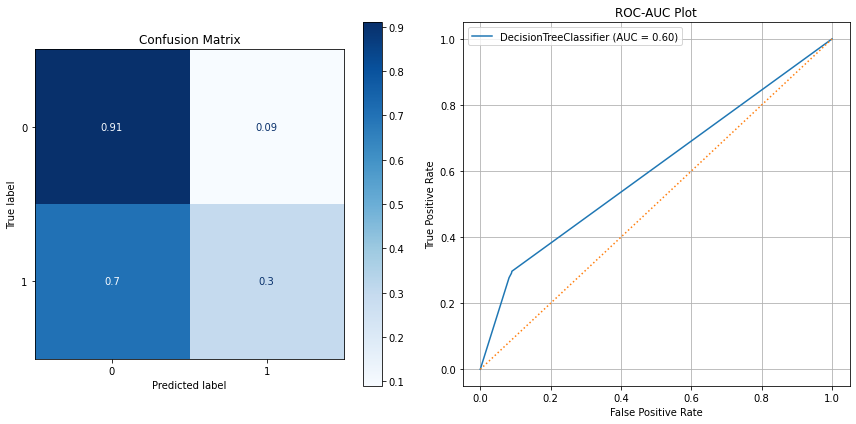

In [40]:
dectree_clf = DecisionTreeClassifier(class_weight = 'balanced') # Decision Tree 
dectree_clf.fit(X_train, y_train)  # fit model
dectree_prediction = dectree_clf.predict(X_test)
decision_tree_score = round(accuracy_score(dectree_prediction, y_test)*100,2)
print('Accuracy Percentage', decision_tree_score, '\n')
print(classification_report(y_test, dectree_prediction), '\n\n')

model_visuals (dectree_clf, X_test, y_test) # class report / plots

## Gradient Boosting

Accuracy Percentage 89.81 

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6738
           1       0.59      0.22      0.32       829

    accuracy                           0.90      7567
   macro avg       0.75      0.60      0.63      7567
weighted avg       0.88      0.90      0.88      7567
 




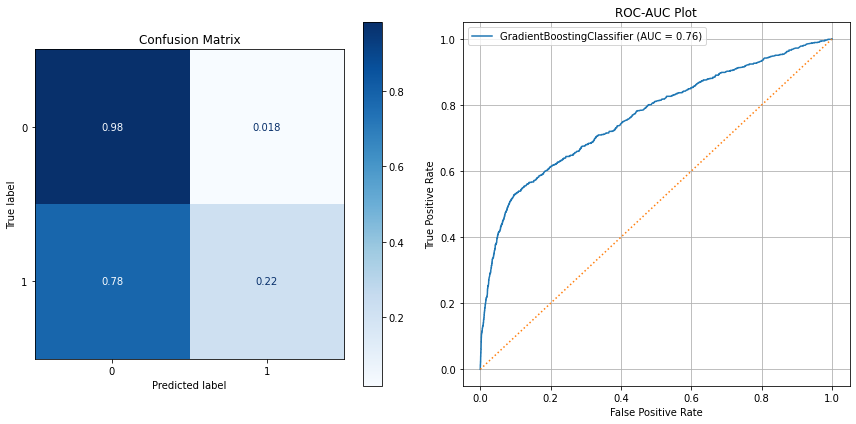

In [41]:
gb_clf = GradientBoostingClassifier() # Gradient Boosting Classifier
gb_clf.fit(X_train, y_train) # fit model
gb_prediction = gb_clf.predict(X_test)
gbclf_score = round(accuracy_score(gb_prediction, y_test)*100,2)
print('Accuracy Percentage', gbclf_score, '\n')
print(classification_report(y_test, gb_prediction), '\n\n')

model_visuals (gb_clf, X_test, y_test) # class report / plots

## Adaboost

Accuracy Percentage 89.78 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6738
           1       0.61      0.18      0.28       829

    accuracy                           0.90      7567
   macro avg       0.76      0.58      0.61      7567
weighted avg       0.88      0.90      0.87      7567
 




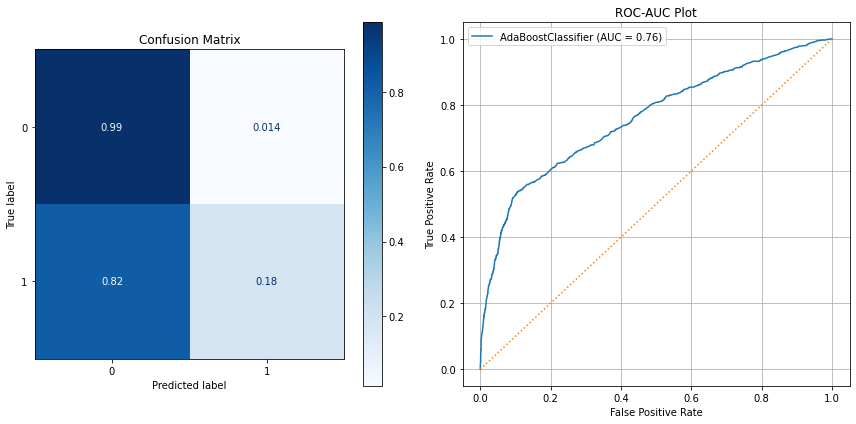

In [42]:
adabst_clf = AdaBoostClassifier() # AdaBoost
adabst_clf.fit(X_train, y_train) # fit model
adabst_prediction = adabst_clf.predict(X_test)
adabst_score = round(accuracy_score(adabst_prediction, y_test)*100,2)
print('Accuracy Percentage', adabst_score, '\n')
print(classification_report(y_test, adabst_prediction), '\n\n')

model_visuals (adabst_clf, X_test, y_test) # class report / plots

# Interpret Models

In [43]:
# Dataframe of Results
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'KNN', 
              'Random Forest', 
              'Gaussian Naive Bayes',
              'Support Vector Machine (SVC)', 
              'Decision Tree', 
              'AdaBoost Classifier', 
              'Gradient Boosting Classifier',
             ],
    'Score': [lrs, 
              knn_score, 
              random_forest_score, 
              gaussian_score,
              svm_score, 
              decision_tree_score,
              adabst_score, 
              gbclf_score, 
             ]})

models.sort_values(by='Score', ascending=False) # Sorting by score

,Model,Score
7,Gradient Boosting Classifier,89.81
6,AdaBoost Classifier,89.78
1,KNN,89.30
2,Random Forest,88.94
5,Decision Tree,84.29
4,Support Vector Machine (SVC),83.18
0,Logistic Regression,81.74
3,Gaussian Naive Bayes,66.88


<div class="alert alert-block alert-info">

Gradient Boosting Classifier scored the highest on accuracy with AdaBoost at close second place. Guassian Naive Bayes scored the lowest (approx 23 percentage points lower than the top model).

The unbalanced target variable leads us to interpret the models based on precision, recall and F1 score as well as accuracy. Fortunately, Gradient Boosting Classifier and Ada Boost Classifier performed well with precision scores of 0.68 and F1 scores over 0.32. 

</div>

## Gradient Boosting Classifier with GridSearchCV
Let's see if we can improve our results at all using GridSearch.

``` Python
# Grid Search Parameters
learn_rates = [0.05, 0.1]
max_depths = [2, 3]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

grid_search = GridSearchCV(GradientBoostingClassifier(), 
                           param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
```

```
GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10]},
             return_train_score=True)

```

``` Python
print(grid_search.score(X_train, y_train))
print(grid_search.best_params_)
```

``` 
0.9074869490517412
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
```

<div class="alert alert-block alert-info">

Gridsearch CV did not raise the accuracy of the model. Let's see if we can improve the accuracy by addressing our class imbalance problem.

</div>

## Class Imbalance

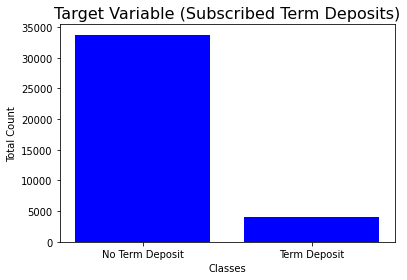

In [44]:
# Visualizing churn
plt.bar(['No Term Deposit', 'Term Deposit'], df.term_deposit_yes.value_counts().values, facecolor = 'blue',  linewidth=0.5)
plt.title('Target Variable (Subscribed Term Deposits)', fontsize=16)
plt.xlabel('Classes')
plt.ylabel('Total Count')
plt.show()

<div class="alert alert-success">

The graph above illustrates a pretty high level of feature imbalance. The imbalance will be treated using SMOTE.

</div>

## SMOTE (Synthetic Minority Over-sampling Technique)

In [45]:
# Separate target and features
y = df['term_deposit_yes']
X = df.drop(['term_deposit_yes'], axis=1) 

In [46]:
# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101) 

In [47]:
# Standardize the data
scaler = StandardScaler() # transform "X" features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
from imblearn.over_sampling import SMOTE #import smote

In [49]:
smote = SMOTE(random_state=101) #random state 101 for consistency

In [50]:
X_res, y_res = smote.fit_resample(X_train, y_train) #fitting smote to our train sets

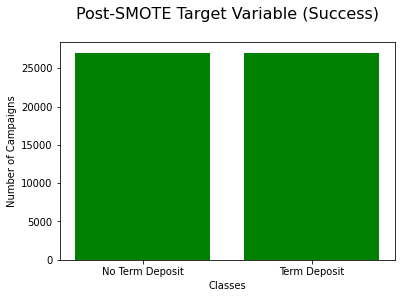

In [51]:
# Updated bar graph to display amount of failed vs. successful campaigns post-SMOTE
plt.bar(['No Term Deposit', 'Term Deposit'], [sum(y_res), len(y_res)-sum(y_res)], facecolor = 'green',  linewidth=0.5)
plt.title('Post-SMOTE Target Variable (Success)\n', fontsize=16)
plt.xlabel('Classes')
plt.ylabel('Number of Campaigns')
plt.show()

<div class="alert alert-success">

It looks like our classes are balanced now. Let's proceed.

</div>

In [52]:
# Rerunning top models
adabst_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
ranfor_clf = RandomForestClassifier()
dectree_clf = DecisionTreeClassifier()

classifiers = [adabst_clf, gb_clf, ranfor_clf, dectree_clf] # Classifiers
classifiers_names = ['AdaBoost', 'Gradient Boost', 'Random Forest', 'Decision Tree'] # respective names

In [53]:
# Iterating through classifiers and appending accuracy to list of scores
scores = []
for i in range(len(classifiers)):
    classifiers[i].fit(X_res, y_res)
    scores.append(round(classifiers[i].score(X_test, y_test), 3))

In [54]:
# dataframe to compare results
dfsmote = pd.DataFrame({'Model': classifiers_names, 'Score': scores})

dfsmote.sort_values(by='Score', ascending=False) # sorting models by score

,Model,Score
1,Gradient Boost,0.884
2,Random Forest,0.882
0,AdaBoost,0.866
3,Decision Tree,0.837


<div class="alert alert-block alert-info">

The models performed worse than they did initially. SMOTE did not significantly impact model performance. 

</div>

# Feature Importance of Top Classifiers

Now that we know which classifiers have the most accuracy with our data, let's compare which features were the most important in the top two models: **Gradient Boosting Classifier and Adaboost.**

## Gradient Boosting Classifier

In [55]:
# Feature Importance
gb_model = gb_clf.fit(X_train, y_train)
gb_feature = pd.DataFrame({'Importance': gb_model.feature_importances_, 'Column': X.columns})
gb_feature = gb_feature.sort_values(by='Importance', ascending=False) 
print('Gradient Boosting Classifier Top 25 Features')
gb_feature[:25] # top 25 features

Gradient Boosting Classifier Top 25 Features


,Importance,Column
6,0.619132,nremployed
2,0.092244,pdays
5,0.075118,consconfidx
44,0.040695,poutcome_success
37,0.026697,month_oct
0,0.024262,age
4,0.024181,conspriceidx
29,0.022565,contact_telephone
34,0.012716,month_mar
3,0.012653,previous


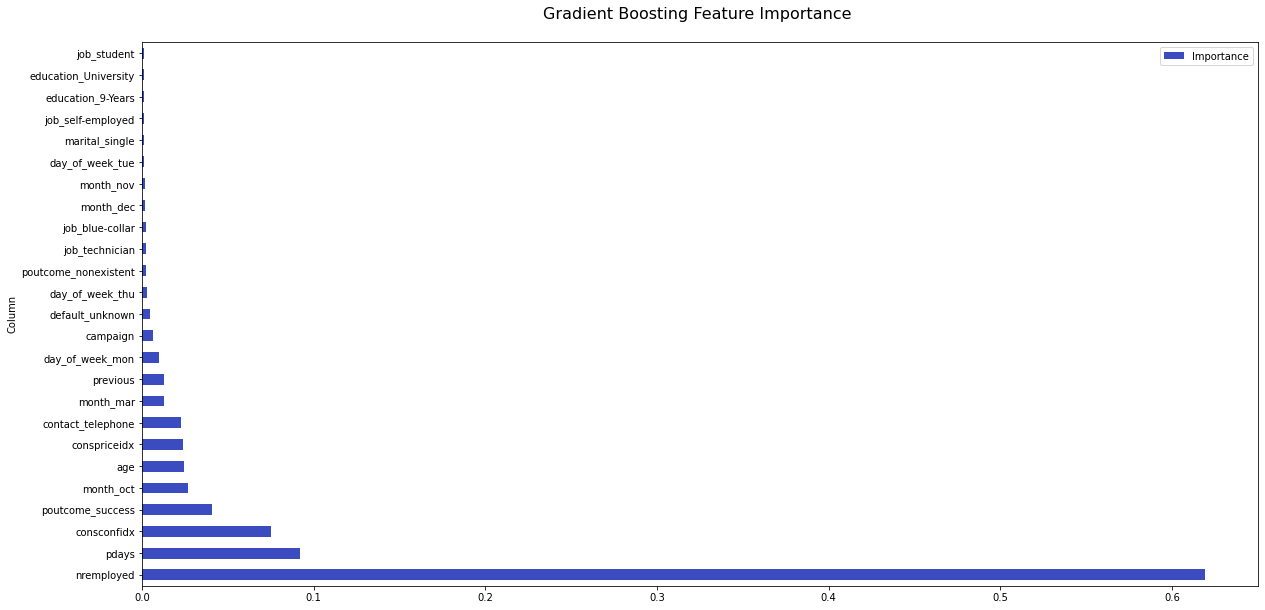

In [56]:
gb_feature = gb_feature[:25] # top 25 features
gb_feature.plot(kind='barh', x='Column', y='Importance', figsize=(20, 10), cmap = 'coolwarm')
plt.title('Gradient Boosting Feature Importance \n', fontsize=16)
plt.show()

## Adaboost Features

In [57]:
# Feature Importance
adabst_model = adabst_clf.fit(X_train, y_train)
ada_feature = pd.DataFrame({'Importance': adabst_model.feature_importances_, 'Column': X.columns})
ada_feature = ada_feature.sort_values(by='Importance', ascending=False) 
print('Adaboost Top 25 Features')
ada_feature[:25] 

Adaboost Top 25 Features


,Importance,Column
5,0.18,consconfidx
1,0.12,campaign
4,0.12,conspriceidx
37,0.08,month_oct
6,0.06,nremployed
34,0.06,month_mar
0,0.06,age
2,0.04,pdays
42,0.02,day_of_week_wed
40,0.02,day_of_week_thu


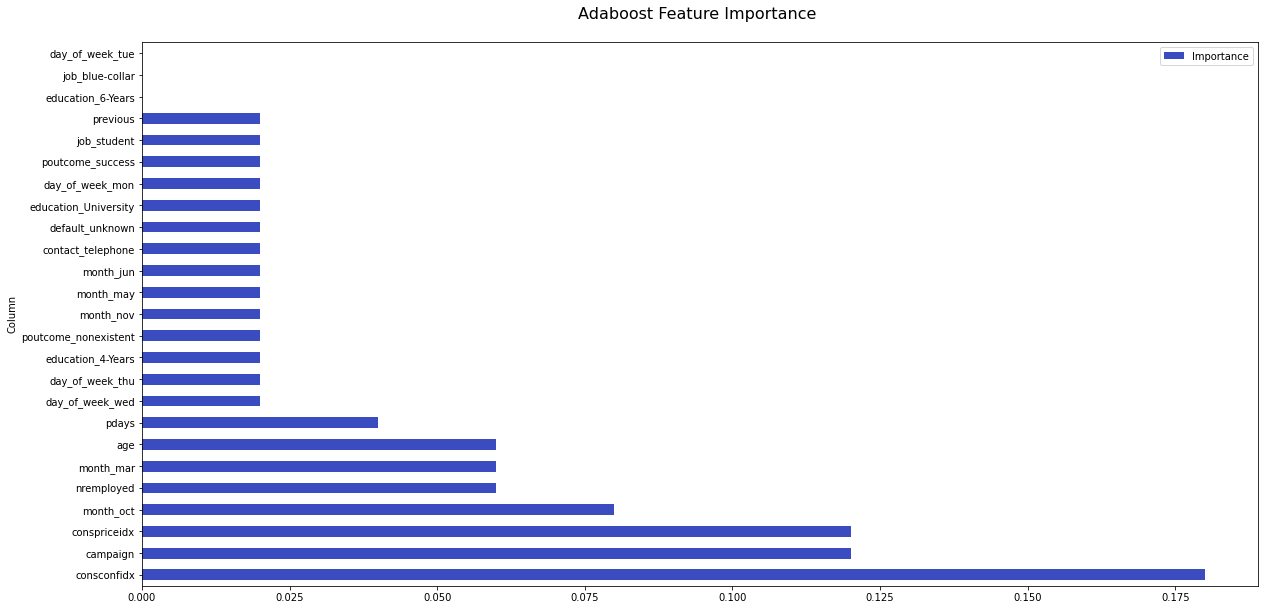

In [58]:
ada_feature = ada_feature[:25] # top 25 features
ada_feature.plot(kind='barh', x='Column', y='Importance', figsize=(20, 10), cmap = 'coolwarm')
plt.title('Adaboost Feature Importance \n', fontsize=16)
plt.show()

## Overlap

In [59]:
# Creating lists / top 25 features in each classifier 
gb = gb_feature.Column.unique() 
ada = ada_feature.Column.unique()

In [60]:
set(gb) & set(ada) # items appearing in both lists

{'age',
 'campaign',
 'consconfidx',
 'conspriceidx',
 'contact_telephone',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'default_unknown',
 'education_University',
 'job_blue-collar',
 'job_student',
 'month_mar',
 'month_nov',
 'month_oct',
 'nremployed',
 'pdays',
 'poutcome_nonexistent',
 'poutcome_success',
 'previous'}

<div class="alert alert-success">

There are 19 total items that appear in both classifier feature lists. 

Top rated features in both lists include:
* Age
* Number of employees | quarterly indicator (nremployed)
* Campaign | (number of contacts / this campaign)
* Days since last campaign contact | Pdays

</div>

## Visualizing Important Features

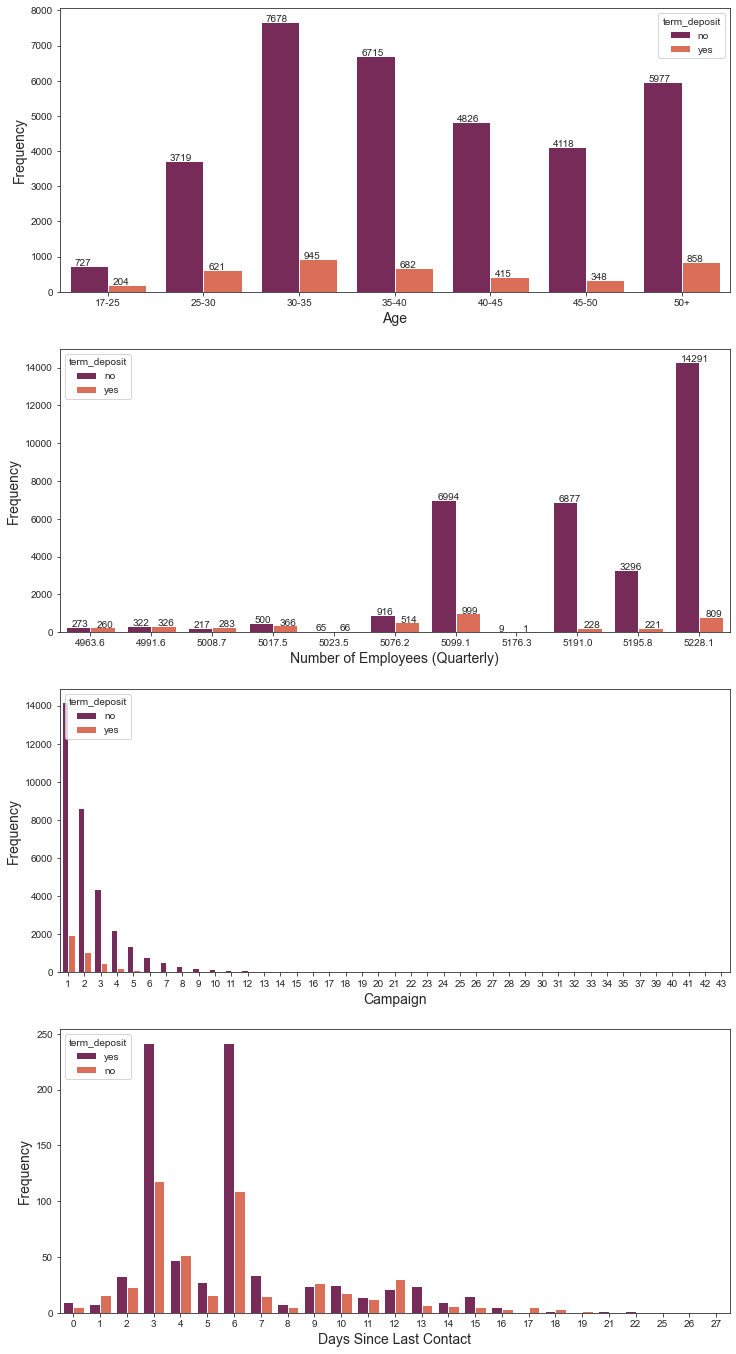

In [61]:
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,24))

df2 = df2.sort_values(['Age(bin)'], ascending=True)
ax1 = sns.countplot(x='Age(bin)',data=df2,hue='term_deposit',palette='rocket', ax=ax[0])
ax1.set_xlabel('Age',fontdict={'fontsize': 14})
ax1.set_ylabel('Frequency',fontdict={'fontsize': 14})
for p in ax1.patches:
        ax1.annotate(p.get_height(),(p.get_x()+0.05, p.get_height()+5))

ax2 = sns.countplot(x='nr.employed',data=df2,hue='term_deposit',palette='rocket',ax=ax[1])
ax2.set_xlabel('Number of Employees (Quarterly)',fontdict={'fontsize': 14})
ax2.set_ylabel('Frequency',fontdict={'fontsize': 14})
for p in ax2.patches:
        ax2.annotate(p.get_height(),(p.get_x()+0.1, p.get_height()+3))

ax3 = sns.countplot(x='campaign',data=df2,hue='term_deposit',palette='rocket',ax=ax[2])
ax3.set_xlabel('Campaign', fontdict={'fontsize': 14})
ax3.set_ylabel('Frequency', fontdict={'fontsize': 14})

df3 = df2[df2['pdays']!= 999] # dropping 999 (no contact per value keys)
ax4 = sns.countplot(x='pdays',data=df3,hue='term_deposit',palette='rocket',ax=ax[3])
ax4.set_xlabel('Days Since Last Contact', fontdict={'fontsize': 14})
ax4.set_ylabel('Frequency', fontdict={'fontsize': 14})

plt.show()

# Conclusion, Insights, Limitations and Future Work

## Conclusion

The dataset offered various consumer trends and illustrated multiple areas of opportunity. In most cases, the features that related to these constants represented both; highest number of subscribers and highest number of non-subscribers. This leads us to believe that consistency and performance metrics are not followed as the volume of work increases resulting in a natural increase of total subscribers but an exponential increase in consumers who decline term deposit products. Selected customer and bank features will be evaluated in the business recommendations below. 

## Business Recommendations

1) Consumers between the ages of 30 and 40 make up the largest amount of term deposit subscribers but also reflect the largest amount of non-subscribing customers. The age group with the smallest gap between subscribing and non-subscribing customers includes customers ages 17 to 25. Construct and apply similarly structured marketing, outreach and advertising techniques to the customer age segment 30 to 40 in order to convert additional non-subscribing customers. 

2) The gap between number of subscribing and non-subscribing customers begins to grow significantly once the number of quarterly employed employees goes over 5076. While the number of subscribed term deposits does continue to grow the level of productivity declines dramatically. Review bank productivity guidelines and drive performance per employee when employee levels go over 5076. 

3) When considering the number of times a consumer has been contacted for the current campaign – there is an obvious decline in the number of subscriber term deposits as the number of contacts per customer increase. Deploy an A team (high performers) to handle customer outreach during the first three contacts to increase the chance of conversion. 

4) The 'days since last contact' data show an abundance of non-subscribing and subscribing consumers in the '999' or 'has not been contacted' category. Deploy a B team to (high performers) to field incoming marketing calls that arrive from numbers that are not registered in the bank's database. In addition, consider methods of dividing customers into 'new' and 'existing' during day-to-day operations.  High performing team members should be deployed to address new bank customers.  

## Limitations

The dataset and business insights are limited to customers who specifically cite their job type, marital status and education level when registering as a bank customer. Additionally, the models and features reflect clients that are between 17 and 69 years of age. 

## Future Work
In order to more accurately define the boundaries of our features it is important to understand what customs and cultural influences are tied to this dataset (Portuguese banking info). For example: knowing the average level of education, the geographic locations of client residences and information on financial markets in this region may alter the way we perceive these variables.

Additionally, the dataset illustrates that the vast majority of subscribing consumers enroll in bank products when they are not contacted by telemarketers. It would be helpful to review additional data on these consumers in order to evaluate different means of product conversion (such as social media, the Internet, day-to-day walk-ins, etc.)